In [48]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing  
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.ticker import MultipleLocator 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# train

In [51]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info.index = shop_info['shop_id'].tolist()

In [3]:
shop_info_num = shop_info.iloc[:,:10].copy()

In [4]:
weekA = shop_info.loc[:,'2016-09-20':'2016-09-26'].copy()
weekB = shop_info.loc[:,'2016-10-11':'2016-10-17'].copy()
weekC = shop_info.loc[:,'2016-10-18':'2016-10-24'].copy()
weekD = shop_info.loc[:,'2016-10-25':'2016-10-31'].copy()

In [5]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
train_x = weekA.join(weekB)                                    #train = weekA+ weekB + weekC
train_x = train_x.join(weekC)

In [6]:
train_x

,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-10-11,2016-10-12,2016-10-13,...,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24
1,223,206,220,241,272,240,225,254,239,228,...,264,264,207,244,177,207,230,202,243,216
2,77,82,71,71,96,121,67,0,0,0,...,0,0,0,0,0,0,61,155,143,78
3,62,59,55,79,112,83,88,68,63,56,...,119,97,75,59,71,88,103,127,125,47
4,74,101,102,98,203,199,91,86,113,71,...,165,200,89,90,112,59,80,211,221,81
5,277,272,309,182,179,4,305,223,218,230,...,185,211,274,201,210,221,187,161,240,454
6,77,68,74,73,67,89,83,83,91,90,...,112,137,83,104,104,90,107,88,76,104
7,105,116,105,141,168,180,109,136,93,128,...,183,208,135,101,94,113,132,152,200,124
8,62,65,57,71,69,73,55,81,63,65,...,103,101,66,49,55,73,46,68,89,68
9,238,214,229,242,288,324,212,225,202,192,...,251,282,254,180,213,226,208,220,310,246
10,73,104,69,76,73,89,80,108,111,73,...,76,103,96,90,139,93,84,92,115,60


In [7]:

def every_shop_open_ratio(start_day,end_day):
    Row = len(shop_info.index.tolist())
    row = 0
    Open_ratios = []
    while(row<Row):
        single_row = shop_info.iloc[row]
        single_row = single_row[start_day:end_day]
        open_ratio_ = (single_row>0).sum()/float((pd.to_datetime(end_day).date()-pd.to_datetime(start_day).date()).days+1)
        Open_ratios.append(round(open_ratio_,4))
        row = row+1
    Open_ratios = np.array(Open_ratios)
 
  
    mask = Open_ratios>=0
    df = DataFrame({'shop_id':(shop_info.shop_id)[mask].values,'open_ratio':Open_ratios[mask]},index=np.arange(1,2001))
    return  df   #返回大于threshold的shop_id,以及他们对应的开张比例


In [8]:
train_sum = train_x.sum(axis=1)
train_mean = train_x.mean(axis=1)
train_open_ratio_A = every_shop_open_ratio(start_day='2016-09-20',end_day='2016-09-26')
train_open_ratio_BC = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-24')
train_open_ratio = (train_open_ratio_A.open_ratio + train_open_ratio_BC.open_ratio*2)/3
train_weekend = ['2016-09-24','2016-09-25','2016-10-15','2016-10-16','2016-10-22','2016-10-23']
train_ratio_wk = (train_x[train_weekend]).sum(axis=1)/(train_sum.replace(0,1))
train_std = train_x.std(axis=1)
train_max = train_x.max(axis=1)
train_min = train_x.min(axis=1)
train_median = train_x.median(axis=1)
train_mad = train_x.mad(axis=1)
train_var = train_x.var(axis=1) 

In [9]:
'''将多维数组转换为DataFrame'''
def transfrom_Arr_DF(arr,col_name = 'col_'):
    if(len(arr.shape)==1):
        df = DataFrame(arr,columns=['col_0'])
    else:
        df = DataFrame(arr,columns=[col_name+str(i) for i in range(arr.shape[1])],index=np.arange(1,len(arr)+1))
    return df

'''将一维数组转换为OHE码'''
def make_OHE(names):
    data = []
    for name in names:
        data.append([name])          
    enc = preprocessing.OneHotEncoder()
    enc.fit(data)
    OHE_data = enc.transform(data).toarray()  
    return OHE_data


In [10]:
shop_info_num['score'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['comment_cnt'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['cate_3_name'].replace(np.NaN,u'NaN',inplace=True)

In [11]:
city_name_usual=[u'上海',u'杭州',u'北京',u'广州',u'南京',u'武汉',u'深圳']
shop_info_num.loc[~shop_info_num['city_name'].isin(city_name_usual),'city_name'] = u'其他城市'
cate_1_name_usual=[u'美食',u'超市便利店']
shop_info_num.loc[~shop_info_num['cate_1_name'].isin(cate_1_name_usual),'cate_1_name'] = u'其他'
cate_2_name_usual=[u'快餐',u'超市',u'便利店',u'休闲茶饮',u'小吃',u'休闲食品',u'烘焙糕点',u'中餐',u'其他美食',u'火锅']
shop_info_num.loc[~shop_info_num['cate_2_name'].isin(cate_2_name_usual),'cate_2_name'] = u'其他'
cate_3_name_usual=[u'西式快餐',u'中式快餐',u'生鲜水果',u'奶茶',u'其它小吃',u'面包',u'饮品/甜点',u'面点',u'蛋糕']
shop_info_num.loc[~shop_info_num['cate_3_name'].isin(cate_3_name_usual),'cate_3_name'] = u'其他'


In [12]:
train_x.head()

,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-10-11,2016-10-12,2016-10-13,...,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24
1,223,206,220,241,272,240,225,254,239,228,...,264,264,207,244,177,207,230,202,243,216
2,77,82,71,71,96,121,67,0,0,0,...,0,0,0,0,0,0,61,155,143,78
3,62,59,55,79,112,83,88,68,63,56,...,119,97,75,59,71,88,103,127,125,47
4,74,101,102,98,203,199,91,86,113,71,...,165,200,89,90,112,59,80,211,221,81
5,277,272,309,182,179,4,305,223,218,230,...,185,211,274,201,210,221,187,161,240,454


In [13]:
poly.fit_transform(train_x)

array([[  2.23000000e+02,   2.06000000e+02,   2.20000000e+02, ...,
          4.90860000e+04,   4.36320000e+04,   5.24880000e+04],
       [  7.70000000e+01,   8.20000000e+01,   7.10000000e+01, ...,
          2.21650000e+04,   1.20900000e+04,   1.11540000e+04],
       [  6.20000000e+01,   5.90000000e+01,   5.50000000e+01, ...,
          1.58750000e+04,   5.96900000e+03,   5.87500000e+03],
       ..., 
       [  3.97000000e+02,   4.12000000e+02,   4.49000000e+02, ...,
          1.03320000e+05,   1.77345000e+05,   1.84664000e+05],
       [  2.70000000e+02,   2.97000000e+02,   2.59000000e+02, ...,
          1.94910000e+05,   1.33500000e+05,   1.31400000e+05],
       [  1.54000000e+02,   1.47000000e+02,   1.68000000e+02, ...,
          3.89400000e+03,   1.06920000e+04,   9.55800000e+03]])

In [14]:
train_x = transfrom_Arr_DF(poly.fit_transform(train_x))

In [15]:

train_x['sumABCD'] = train_sum
train_x['open_ratio'] = train_open_ratio
train_x['ratio_wk'] = train_ratio_wk
train_x['meanABCD'] = train_mean
train_x['std'] = train_std
train_x['max'] = train_max
train_x['min'] = train_min
train_x['median'] = train_median
train_x['mad'] = train_mad
train_x['var'] = train_var

In [16]:
train_x = train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [17]:
train_y = weekD

### 检查 train_x train_y 是否符合要求 不包含NaN

In [18]:
train_x.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,cate_3_name__中式快餐,cate_3_name__其他,cate_3_name__其它小吃,cate_3_name__奶茶,cate_3_name__生鲜水果,cate_3_name__蛋糕,cate_3_name__西式快餐,cate_3_name__面包,cate_3_name__面点,cate_3_name__饮品/甜点
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 开始训练

In [19]:
RF = RandomForestRegressor(n_estimators=1200,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25)
RF.fit(train_x,train_y)
#pre = (RF.predict(test_x)).round()

#ET = ExtraTreesRegressor(n_estimators=1200,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=270)
#ET.fit(train_x,train_y)
#pre = (ET.predict(test_x)).round()


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1200, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [20]:
RF.score(train_x,train_y)

0.96566366376351054

In [21]:
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('RF_feature_importance_.csv', sep=",", index = False)

# test

In [24]:
test_x = weekB.join(weekC)                                         #test = weekB + weekC + weekD 
test_x = test_x.join(weekD)


test_sum = test_x.sum(axis=1)
test_mean = test_x.mean(axis=1)
test_open_ratio = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-31')
test_weekend = ['2016-10-15','2016-10-16','2016-10-22','2016-10-23','2016-10-29','2016-10-30']
test_ratio_wk = (test_x[test_weekend]).sum(axis=1)/(test_sum.replace(0,1))
test_std = test_x.std(axis=1)
test_max = test_x.max(axis=1)
test_min = test_x.min(axis=1)
test_median = test_x.median(axis=1)
test_mad = test_x.mad(axis=1)
test_var = test_x.var(axis=1)



In [25]:
test_x = transfrom_Arr_DF(poly.fit_transform(test_x))

test_x['sumABCD'] = test_sum
test_x['open_ratio'] = test_open_ratio.open_ratio
test_x['ratio_wk'] = test_ratio_wk
test_x['meanABCD'] = test_mean

In [26]:
test_x = test_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [27]:

test_x['std'] = test_std
test_x['max'] = test_max
test_x['min'] = test_min
test_x['median'] = test_median
test_x['mad'] = test_mad
test_x['var'] = test_var


In [60]:
result = RF.predict(test_x)
pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]).to_csv('regression_prediction.csv', sep=",", index = True)

In [81]:
result = pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

In [ ]:
## 预测第二周

In [85]:
result2 = result.copy()
result2.columns= ['predict_'+str(i) for i in range(8,15)]

In [86]:
result2

,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,212.498538,206.908740,222.784119,239.042572,252.837417,251.737746,202.960860
2,62.588502,59.901520,67.110428,85.449865,131.354976,128.968339,66.657881
3,70.060190,68.765203,74.306940,88.028486,115.673109,115.159782,71.190571
4,89.965326,83.482185,87.636577,116.346022,189.571891,192.262767,97.815757
5,187.401339,163.645737,180.574942,196.458319,219.894566,231.257391,182.217463
6,106.974638,107.857020,110.392913,120.139445,113.891967,113.406336,107.703108
7,114.938275,108.075326,124.412542,135.635949,170.148819,172.783225,114.523891
8,52.171075,54.670674,60.397617,62.330464,75.820278,72.189183,52.579308
9,211.460984,207.092887,225.640975,237.214041,254.837854,256.034592,200.259442
10,97.286709,93.040390,97.527611,99.083124,101.672757,102.748990,101.036256


## 结果可视化

In [46]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]


In [52]:
shop_info = shop_info.join(pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]))

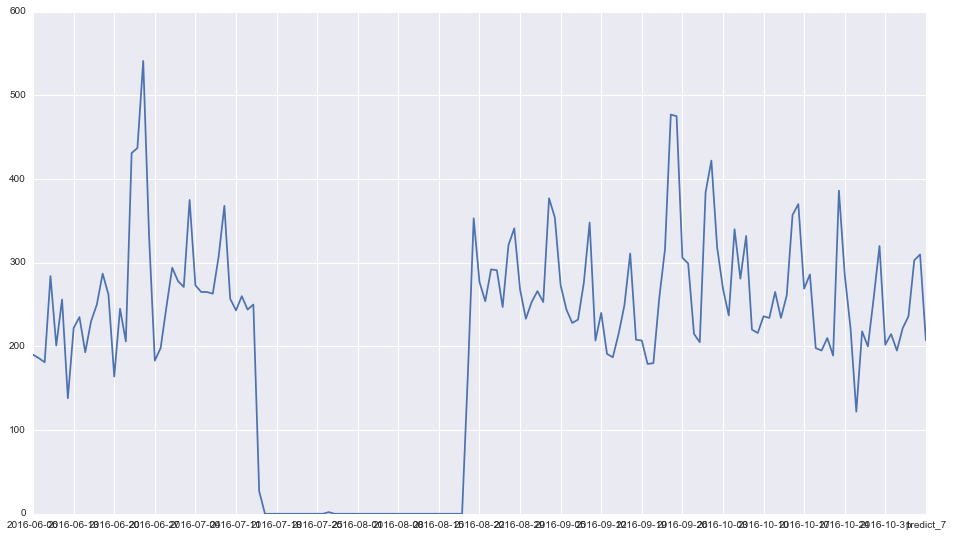

In [78]:

list_result = dateRange('2016-06-06','2016-10-31')
for i in range(1,8):
    list_result.append('predict_'+str(i))

xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
ax = plt.subplot(111) 
ax.xaxis.set_major_locator(xmajorLocator)
shop_info.loc[39,list_result].T.plot(figsize=(16,9),ax=ax)

In [61]:

#  占个格子 &&  cal avg sales count each day
total_day = pd.to_datetime('2016-11-01').date()-pd.to_datetime('2015-07-01').date() 
total_day = total_day.days
total_week = total_day / 7  # 69个
start_day = pd.to_datetime('2016-11-01').date() - datetime.timedelta(total_week*7)
#print start_day
for week_number in range(total_week): # 0~68
    start_day_of_week = start_day +  datetime.timedelta(week_number*7) 
    end_day_of_week = start_day_of_week + datetime.timedelta(6)
    start_day_of_week =   start_day_of_week.strftime("%Y-%m-%d")
    end_day_of_week = end_day_of_week.strftime("%Y-%m-%d")
    print start_day_of_week,end_day_of_week
    shop_info['wk_'+str(week_number)] = shop_info.loc[:,start_day_of_week:end_day_of_week].mean(axis=1)

2015-07-07 2015-07-13
2015-07-14 2015-07-20
2015-07-21 2015-07-27
2015-07-28 2015-08-03
2015-08-04 2015-08-10
2015-08-11 2015-08-17
2015-08-18 2015-08-24
2015-08-25 2015-08-31
2015-09-01 2015-09-07
2015-09-08 2015-09-14
2015-09-15 2015-09-21
2015-09-22 2015-09-28
2015-09-29 2015-10-05
2015-10-06 2015-10-12
2015-10-13 2015-10-19
2015-10-20 2015-10-26
2015-10-27 2015-11-02
2015-11-03 2015-11-09
2015-11-10 2015-11-16
2015-11-17 2015-11-23
2015-11-24 2015-11-30
2015-12-01 2015-12-07
2015-12-08 2015-12-14
2015-12-15 2015-12-21
2015-12-22 2015-12-28
2015-12-29 2016-01-04
2016-01-05 2016-01-11
2016-01-12 2016-01-18
2016-01-19 2016-01-25
2016-01-26 2016-02-01
2016-02-02 2016-02-08
2016-02-09 2016-02-15
2016-02-16 2016-02-22
2016-02-23 2016-02-29
2016-03-01 2016-03-07
2016-03-08 2016-03-14
2016-03-15 2016-03-21
2016-03-22 2016-03-28
2016-03-29 2016-04-04
2016-04-05 2016-04-11
2016-04-12 2016-04-18
2016-04-19 2016-04-25
2016-04-26 2016-05-02
2016-05-03 2016-05-09
2016-05-10 2016-05-16
2016-05-17

In [62]:
shop_info['result_avg'] = shop_info.loc[: ,['predict_'+str(i) for i in range(1,8)]].mean(axis=1)

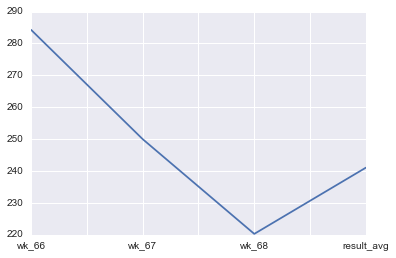

In [76]:
shop_info.loc[39,'wk_66':'result_avg'].plot()

In [ ]:
## 保存结果

In [101]:
result_total = result.join(result2)

In [105]:
for i in range(1,15):
    result_total.loc[:,'predict_'+str(i)] = result_total.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))
    

In [106]:
result_total

,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,212,207,223,239,253,252,203,212,207,223,239,253,252,203
2,63,60,67,85,131,129,67,63,60,67,85,131,129,67
3,70,69,74,88,116,115,71,70,69,74,88,116,115,71
4,90,83,88,116,190,192,98,90,83,88,116,190,192,98
5,187,164,181,196,220,231,182,187,164,181,196,220,231,182
6,107,108,110,120,114,113,108,107,108,110,120,114,113,108
7,115,108,124,136,170,173,115,115,108,124,136,170,173,115
8,52,55,60,62,76,72,53,52,55,60,62,76,72,53
9,211,207,226,237,255,256,200,211,207,226,237,255,256,200
10,97,93,98,99,102,103,101,97,93,98,99,102,103,101


In [91]:
result_total.dtypes

predict_1     float64
predict_2     float64
predict_3     float64
predict_4     float64
predict_5     float64
predict_6     float64
predict_7     float64
predict_8     float64
predict_9     float64
predict_10    float64
predict_11    float64
predict_12    float64
predict_13    float64
predict_14    float64
dtype: object

In [88]:
result_total.to_csv('regression_prediction.csv', sep=",", index = True)

,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,212.498538,206.908740,222.784119,239.042572,252.837417,251.737746,202.960860,212.498538,206.908740,222.784119,239.042572,252.837417,251.737746,202.960860
2,62.588502,59.901520,67.110428,85.449865,131.354976,128.968339,66.657881,62.588502,59.901520,67.110428,85.449865,131.354976,128.968339,66.657881
3,70.060190,68.765203,74.306940,88.028486,115.673109,115.159782,71.190571,70.060190,68.765203,74.306940,88.028486,115.673109,115.159782,71.190571
4,89.965326,83.482185,87.636577,116.346022,189.571891,192.262767,97.815757,89.965326,83.482185,87.636577,116.346022,189.571891,192.262767,97.815757
5,187.401339,163.645737,180.574942,196.458319,219.894566,231.257391,182.217463,187.401339,163.645737,180.574942,196.458319,219.894566,231.257391,182.217463
6,106.974638,107.857020,110.392913,120.139445,113.891967,113.406336,107.703108,106.974638,107.857020,110.392913,120.139445,113.891967,113.406336,107.703108
7,114.938275,108.075326,124.412542,135.635949,170.148819,172.783225,114.523891,114.938275,108.075326,124.412542,135.635949,170.148819,172.783225,114.523891
8,52.171075,54.670674,60.397617,62.330464,75.820278,72.189183,52.579308,52.171075,54.670674,60.397617,62.330464,75.820278,72.189183,52.579308
9,211.460984,207.092887,225.640975,237.214041,254.837854,256.034592,200.259442,211.460984,207.092887,225.640975,237.214041,254.837854,256.034592,200.259442
10,97.286709,93.040390,97.527611,99.083124,101.672757,102.748990,101.036256,97.286709,93.040390,97.527611,99.083124,101.672757,102.748990,101.036256
